# Absolute Estimates of Protein Concentration in Xenopus

### Chirag Kumar - 11.02.2021

### This script uses the normalization method for estimating absolute protein concentrations in the Xenopus egg.

## Prep Workspace

### Import and Set-up Packages: Python and R

In [1]:
# python packages
# standard packages
import pandas as pd # for dataframes
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
import matplotlib as mpl # for matplotlib settings
import os # for directories
import scipy as sp # for numerical processes and optimizations
import re

# for machine learning and stats
import statsmodels.api as sm # for statistical models and GLMs

In [2]:
# configure R
%load_ext rpy2.ipython

In [3]:
%%R -r 200
# get necessary R packages
library(ggplot2)
library(ggridges)
library(RColorBrewer)
library(grDevices)
# change ggplot default theme to be black and white
ggplot2::theme_set(theme_bw())

In [4]:
# configure plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]
font = {'family' : 'Nimbus Roman',
        'weight' : 'bold',
        'size'   : 22}

mpl.rc('font', **font)

In [5]:
seed = 108

### Define Directories

In [6]:
# define directories

# this is a hack to be able to refer to relative locations
if '__file__' not in globals():
    __file__ = '.'

inp_dir = os.path.abspath(os.path.dirname(__file__))
data_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                        'Data'))
out_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                       'Result Files'))
fig_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                          'Figures'))

### Get Data

In [7]:
# peptide data from allosaurus
peps = pd.read_csv(os.path.join(data_dir, 'Xenopus-v9p2-proteins_02-26-2021-Area.csv'))

In [8]:
peps.shape

(197667, 20)

In [9]:
peps.head()

,Reference,Protein ID,z,Pept. Length,Peptide,Trimmed Peptide,Stripped Peptide,Area,Max,Max Sn,Max Norm Sn,S:N Area,Norm Sn Area,concentration,num,occurences,num_theoretical_peps,Protein_id_2,Number of Theoretical peps,Description
0,gnl|gene15050|rna43914|,gnl|gene15050|rna43914|,3,23,RAAAAADLANNSPESNAVQDIEEKD,AAAAADLANNSPESNAVQDIEEK,AAAAADLANNSPESNAVQDIEEK,182300000.0,23810000.0,33.1,182900.0,259.0,1653000.0,0.4,1,2,NaN,gnl|gene15050|rna43914| clpx.L,67,NAN
1,gnl|gene15050|rna43914|,gnl|gene15050|rna43914|,2,23,RAAAAADLANNSPESNAVQDIEEKD,AAAAADLANNSPESNAVQDIEEK,AAAAADLANNSPESNAVQDIEEK,173600000.0,22250000.0,30.3,166300.0,232.1,1480000.0,0.4,1,2,NaN,gnl|gene15050|rna43914| clpx.L,67,NAN
2,gnl|gene15050|rna43914|,gnl|gene15050|rna43914|,4,21,KCELSISEDALRAIARLALERKT,CELSISEDALRAIARLALERK,CELSISEDALRAIARLALERK,2241000.0,359100.0,13.6,2975.0,79.0,20806.2,0.4,1,1,NaN,gnl|gene15050|rna43914| clpx.L,67,NAN
3,gnl|gene15050|rna43914|,gnl|gene15050|rna43914|,2,15,RDLIEFGM*IPEFVGRL,DLIEFGM*IPEFVGR,DLIEFGMIPEFVGR,1354000.0,556300.0,13.4,3242.4,29.5,8776.0,0.4,1,1,NaN,gnl|gene15050|rna43914| clpx.L,67,NAN
4,gnl|gene15050|rna43914|,gnl|gene15050|rna43914|,2,11,KEPESAAEAM*KL,EPESAAEAM*K,EPESAAEAMK,4272000.0,930400.0,26.6,14287.6,116.3,66273.4,0.4,1,1,NaN,gnl|gene15050|rna43914| clpx.L,67,NAN


In [10]:
peps = peps.drop(['concentration', 'num', 'occurences'], axis = 1)

In [11]:
# get protein mapping data
#protein_human_map = pd.read_excel(os.path.join(data_dir, '210113_xenla_v9p2_humanGN.xlsx'), sheet_name = 1)
protein_phrog_map = pd.read_excel(os.path.join(data_dir, '210216_xenla_v9p2_phrog.xlsx'), sheet_name = 1)

In [12]:
protein_phrog_map.head()

,ProteinId,laevisGene,Contigs,AA,E_LtoP,E_PtoL
0,gnl|gene10000|rna29070|,LOC495506.S,CL7211Contig1,MEVLTLLLSLLILLSIVLMSWRRHKKRLDLPPGPVPLPLLGNVLQG...,0.0,0.0
1,gnl|gene10001|rna29072|,prdm12.L,CL11856Contig1,MMGSVLPAEALVLKAGLKQPGLSLAELITSDILHSFLYGRWRNVLG...,0.0,0.0
2,gnl|gene10002|rna29075|,mmel1.L,CL6782Contig3,MENEVAKAVDNQMEKYIVTIMGKSESQMDIVEKSTKSAKKSWSFVE...,0.0,0.0
3,gnl|gene10003|rna29078|,clptm1l.S,CL8510Contig1,MLNRSSFTTLVVGVFIVYVVHTCWVMYGIVYTKPCESHSDNCIKPY...,0.0,0.0
4,gnl|gene10004|rna29080|,rftn1.L,CL15701Contig1,MGCGLNKLEKLDDKRPGNIYSTLKRPHVETKIDVAYEYKYVDFTTL...,0.0,0.0


In [13]:
phrog_map_hold = protein_phrog_map.copy(deep = True)

In [14]:
protein_phrog_map = protein_phrog_map[protein_phrog_map['E_LtoP'] <= 10 ** (-100)]

In [15]:
protein_phrog_map.sort_values(by = ['E_LtoP'], ascending = False)

,ProteinId,laevisGene,Contigs,AA,E_LtoP,E_PtoL
22348,gnl|gene38650|rna79885|,LOC108704530,dsrrswapns_comp210753_c3_seq1,MHNFLRTENSFCYLLLTLLADLKGSLQCDTEEKLFQKLLARYNHHI...,9.220000e-101,2.660000e-105
17598,gnl|gene31905|rna71425|,Xelaev18030486m,CL20104Contig1,MVLQPLVTQLDLFVIDTSHLLREINGLTLDSDCILVVLDVEALYMS...,9.100000e-101,4.280000e-101
12720,gnl|gene22920|rna62409|,Xelaev18022020m,CL5926Contig2,MVAKKNGLSDCTLESVWSVYDVLFCEKMHNFCLPTWATTNVLAKLK...,9.080000e-101,1.110000e-100
12755,gnl|gene22991|rna62482|,Xelaev18004113m,dsrrswapns_comp216157_c1_seq5,CKTVVWLLGHSYVSRAQRRAAVKKRHGRQLGFPEGRISIQWFGFPG...,8.580000e-101,7.380000e-101
13550,gnl|gene24504|rna63999|,Xelaev18012767m,CL1629Contig2,MGIFPNSQTNCTCYLLFLRWEMPARAIYNAFLSQDTESILRLSGGH...,8.300000e-101,5.860000e-101
...,...,...,...,...,...,...
11285,gnl|gene20405|rna59607|,mgea5.L,CL63Contig15,MVQKDGQATAAITEEETEAAPTTLAPELTPPATTGEDTDTETETCC...,0.000000e+00,0.000000e+00
11284,gnl|gene20404|rna59605|,dcaf4.L,CL5799Contig1,MGPKRENNRNWNRKYQGRRFHQRFPSEASQSSTESNIMDRTSSASS...,0.000000e+00,0.000000e+00
11282,gnl|gene20402|rna59599|,peli2.S,dsrrswapns_comp209386_c6_seq5,MFSPDQENHPAKAPVKYGELIVLGYNGALPNGDRGRRKSRFALLKR...,0.000000e+00,0.000000e+00
11281,gnl|gene20401|rna59598|,insm1.S,dsrrswapns_comp212818_c6_seq9,MPKGFLVKRSRKSPPVSYRVREEEEETRGGWMILATLCPSGGAPPP...,0.000000e+00,0.000000e+00


In [16]:
# get concentration data from deep proteomics paper
protein_conc = pd.read_excel(os.path.join(data_dir,
                                        'NIHMS607488-supplement-02--XenopusProteinConcentrationEstimates.xlsx'))

In [17]:
protein_conc

,Protein ID,Gene Symbol (human),Description (human),PSMs,summed ion current (A.U.),# theoretical peptides,normalized ion current,Estimated Protein Concentration (nM)
0,CL13623Contig1,SERPINA1,Alpha-1-antitrypsin,5880,2.250780e+07,45,500173.333333,17674.015875
1,CL20716Contig1,ACTG1,"Actin, cytoplasmic 2",3951,1.057270e+07,29,364575.862069,14398.991193
2,CL1514Contig1,ENO1,Alpha-enolase,4651,1.355090e+07,40,338772.500000,13730.023453
3,CL2685Contig1,TPI1,Triosephosphate isomerase,2173,8.309680e+06,31,268054.193548,11796.968828
4,BF611742,ACTA2,ACTA2 protein (Fragment),140,7.128510e+05,3,237617.000000,10910.543215
...,...,...,...,...,...,...,...,...
11084,CL5245Contig2,TTK,Dual specificity protein kinase TTK,1,3.188790e+00,94,0.033923,0.399448
11085,CL7399Contig1,RPGR,X-linked retinitis pigmentosa GTPase regulator,1,1.532630e+00,66,0.023222,0.312452
11086,CL10598Contig1,FSCN2,Fascin-2,1,7.803030e-01,35,0.022294,0.304308
11087,CL12915Contig1,ABCB1,Multidrug resistance protein 1,1,1.775560e+00,103,0.017238,0.257587


### Link Datasets

In [18]:
metric = 'Area'

In [19]:
peps = peps.sort_values(by = ['Protein ID', 'Peptide', 'z', metric])

In [20]:
peps['unique'] = (~peps.duplicated(subset = ['Protein ID', 'Stripped Peptide'],
                                keep = 'first')).astype(int)

In [21]:
# make normalized ion signal per protein
peps['Protein ID-v9p2'] = peps['Protein ID']
normalized_signal = peps[['Protein ID-v9p2', metric, 'unique']].groupby('Protein ID-v9p2').sum()

In [22]:
normalized_signal.columns = ['Area', 'unique']

In [23]:
ee1 = peps.copy(deep = True)

In [24]:
ee1 = peps.copy(deep = True)
ee1.index = ee1['Protein ID-v9p2']
normalized_signal['unique'] = pd.DataFrame(ee1.loc[normalized_signal.index.values,
                     'Number of Theoretical peps']).reset_index().drop_duplicates().reset_index(drop = True)['Number of Theoretical peps'].values

In [25]:
normalized_signal['normalized'] = normalized_signal.Area / normalized_signal.unique

In [26]:
normalized_signal.head()

,Area,unique,normalized
Protein ID-v9p2,,,
gnl|gene10000|rna29070|,1.079934e+09,48,2.249862e+07
gnl|gene10003|rna29078|,3.498500e+08,50,6.997000e+06
gnl|gene10006|rna29084|,3.224039e+10,104,3.100037e+08
gnl|gene1000|rna2937|,3.683500e+09,9,4.092778e+08
gnl|gene10010|rna29095|,5.719500e+07,11,5.199545e+06


In [27]:
normalized_signal.shape

(10319, 3)

In [28]:
ff1 = protein_phrog_map.copy(deep = True)

In [29]:
ff1 = ff1.sort_values(by = ['E_PtoL'], ascending = True)

In [30]:
ff1.shape

(27450, 6)

In [31]:
ff1 = ff1.drop_duplicates(subset = ['Contigs'], keep = 'first')

In [32]:
ff1.shape

(21234, 6)

In [33]:
ff1 = ff1.set_index('Contigs')

In [34]:
cc1 = protein_conc.copy(deep = True)

In [35]:
#cc1 = cc1.drop_duplicates(subset = ['Protein ID'], keep = False)

In [36]:
cc1 = cc1.set_index('Protein ID')

In [37]:
cc1.shape

(11089, 7)

In [38]:
gg1 = ff1.join(cc1).dropna(axis = 0).reset_index()

In [39]:
gg1 = gg1.set_index('ProteinId')

In [40]:
gg1.shape

(6773, 12)

In [41]:
gg1.head()

,Contigs,laevisGene,AA,E_LtoP,E_PtoL,Gene Symbol (human),Description (human),PSMs,summed ion current (A.U.),# theoretical peptides,normalized ion current,Estimated Protein Concentration (nM)
ProteinId,,,,,,,,,,,,
gnl|gene10000|rna29070|,CL7211Contig1,LOC495506.S,MEVLTLLLSLLILLSIVLMSWRRHKKRLDLPPGPVPLPLLGNVLQG...,0.0,0.0,CYP2A13,Cytochrome P450 2A13,9.0,225.5080,41.0,5.500195,10.805628
gnl|gene41572|rna84064|,CL2035Contig2,drosha.S,MSLHSGRGGPGTPMQTFRPQNLRPTQLPQSSGQYCYDTQSTPPPTF...,0.0,0.0,DROSHA,Ribonuclease 3,35.0,3543.6800,88.0,40.269091,39.262686
gnl|gene41566|rna84059|,CL1747Contig1,snx17,MHFSIPETESRSSESGAQYLAYNIHVNGVLHCRVRYSQLLGLHEQL...,0.0,0.0,SNX17,Sorting nexin-17,17.0,414.9510,36.0,11.526417,17.453806
gnl|gene41560|rna84045|,CL949Contig1,LOC108696891,MVGENFLLGRECNKTCLCTVNGVVECKDFSCGPNAVCKVMDGVQKC...,0.0,0.0,FCGBP,IgGFc-binding protein,2.0,42.6877,253.0,0.168726,1.129720
gnl|gene41652|rna84155|,CL253Contig7,MGC130975,MTSVTLATSEWISFFKEAGIPAGPAVNYAVTFVDNRIQKSMLMDLN...,0.0,0.0,C19ORF47,Uncharacterized protein C19orf47,2.0,39.4390,51.0,0.773314,3.030172


In [42]:
gg1 = gg1.join(normalized_signal).dropna(axis = 0).reset_index()

Text(0, 0.5, 'New Normalized Signal (log10)')

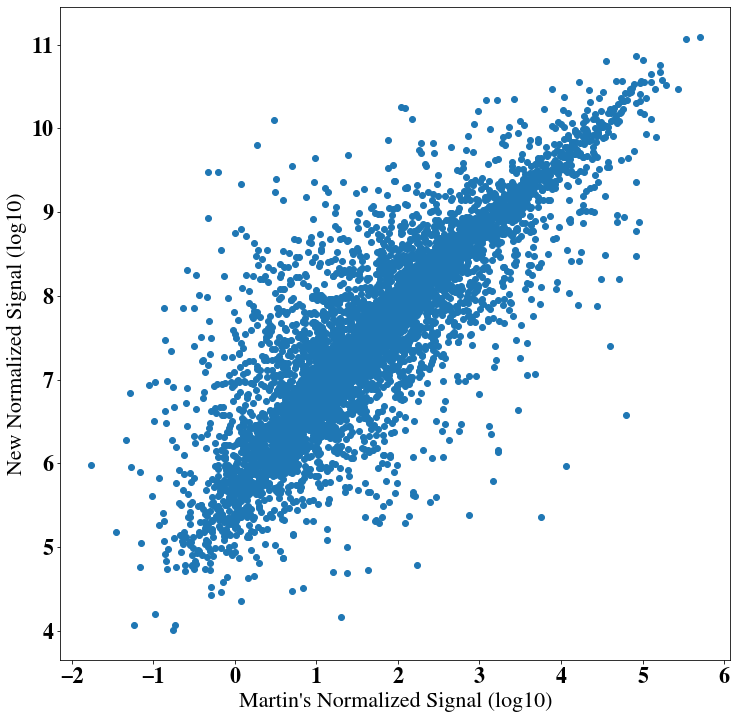

In [43]:
plt.scatter(np.log10(gg1['normalized ion current']), np.log10(gg1['normalized']))
plt.xlabel("Martin's Normalized Signal (log10)")
plt.ylabel('New Normalized Signal (log10)')

In [44]:
gg1['signal difference'] = np.log10(gg1['normalized ion current']) - np.log10(gg1['normalized']) - np.mean(np.log10(gg1['normalized ion current']) - np.log10(gg1['normalized']))

In [45]:
gg1.sort_values(by = 'signal difference', ascending = True)

,ProteinId,Contigs,laevisGene,AA,E_LtoP,E_PtoL,Gene Symbol (human),Description (human),PSMs,summed ion current (A.U.),# theoretical peptides,normalized ion current,Estimated Protein Concentration (nM),Area,unique,normalized,signal difference
4745,gnl|gene19844|rna57956|,dsrrswapns_comp209426_c0_seq1,rab27a.L,MRNRNRESSYDGPTSFPGLMSVTLSGHQPNFKMSDGDYDYLIKFLA...,0.000000e+00,0.000000e+00,RAB27A,Ras-related protein Rab-27A,1.0,1.092960e+01,23.0,0.475200,2.210094,7.471219e+10,25.0,2.988488e+09,-3.984968
13,gnl|gene41512|rna83982|,CL22656Contig1,LOC733413,MLCIIVLGPFLHWASRCKAISLYQASASSSMASASSHREVISLHVG...,0.000000e+00,0.000000e+00,TUBA1A,Tubulin alpha-1A chain,2.0,2.170930e+01,35.0,0.620266,2.626607,1.287903e+11,43.0,2.995124e+09,-3.870230
1781,gnl|gene9517|rna27679|,CL14546Contig1,eef2.2.L,MVNFTVDQIRTIMDKKSNIRNMSVIAHVDHGKSTLTDSLVCKAGII...,0.000000e+00,0.000000e+00,EEF2,Elongation factor 2,8.0,1.932480e+02,63.0,3.067429,7.401051,1.034625e+12,82.0,1.261738e+10,-3.800588
1421,gnl|gene7697|rna22474|,CL4954Contig1,prdx4.L,MCCGCSLLYDVPLLIMALQLRRYLRGSPAVTLCLLLLSAAAVTCEE...,0.000000e+00,0.000000e+00,PRDX4,Peroxiredoxin-4,5.0,3.924560e+01,21.0,1.868838,5.368139,1.443893e+11,23.0,6.277796e+09,-3.712629
5742,gnl|gene5047|rna14748|,CF547730,cox4i2.L,MLSAFHLRSALLPRIRLLGAASIRAAHSHEGQVSRSDGSELLYYDH...,1.480000e-130,1.210000e-130,COX4I2,"Cytochrome c oxidase subunit 4 isoform 2, mito...",4.0,2.260830e+01,19.0,1.189911,4.006470,4.299384e+10,20.0,2.149692e+09,-3.443255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5234,gnl|gene38195|rna79255|,CL28Contig16,krt5.1b,IREINLKNGFGFVEFDDHRDADDAVYELNGKVLCSERVTIEHARNH...,3.520000e-167,3.230000e-167,SRSF4,Serine/arginine-rich splicing factor 4,23.0,3.574940e+03,21.0,170.235238,99.938162,1.298000e+06,21.0,6.180952e+04,3.253601
5924,gnl|gene50249|rna96648|,zeinaSSns_comp383799_c0_seq5,LOC108717084,MIRFLLLFSRQGKLRLQKWYVTLPDKEKRKITRELVQIILSRNPKM...,4.070000e-112,3.860000e-112,AP1S3,AP-1 complex subunit sigma-3,4.0,1.119780e+04,15.0,746.520000,260.493298,4.050000e+06,17.0,2.382353e+05,3.309642
719,gnl|gene3552|rna10337|,CL105Contig9,calr3.L,MWWCLLMAAALMAVSADPLIYFREQFEDGDEWQKRWTESKNKSDFG...,0.000000e+00,0.000000e+00,CALR,Calreticulin,618.0,4.961820e+05,43.0,11539.116279,1536.222981,3.574000e+07,39.0,9.164103e+05,3.913689
493,gnl|gene45585|rna90036|,CL3418Contig2,LOC108706049,MGKVKVGVNGFGRIGRLVTRAAFNSGKVDIVAINDPFIDLNYMVYM...,0.000000e+00,0.000000e+00,GAPDH,Glyceraldehyde-3-phosphate dehydrogenase,2002.0,2.037840e+06,33.0,61752.727273,4555.891223,1.131830e+08,30.0,3.772767e+06,4.027603


In [46]:
fit_ = sm.OLS(endog = np.log10(gg1['Estimated Protein Concentration (nM)'])[gg1['normalized'] != 0],
       exog = sm.add_constant(np.log10(gg1['normalized'][gg1['normalized'] != 0])),
       hasconst = True).fit()

In [47]:
fit_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Estimated Protein Concentration (nM)   R-squared:                       0.711
Model:                                              OLS   Adj. R-squared:                  0.711
Method:                                   Least Squares   F-statistic:                 1.514e+04
Date:                                  Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                                          23:21:29   Log-Likelihood:                -2885.6
No. Observations:                                  6160   AIC:                             5775.
Df Residuals:                                      6158   BIC:                             5789.
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4104      0.033    -72.186      0.000      -2.476      -2.345
normalized     0.5411      0.004    123.025      0.000       0.532       0.550
==============================================================================
Omnibus:                      796.962   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6761.372
Skew:                          -0.328   Prob(JB):                         0.00
Kurtosis:                       8.090   Cond. No.                         52.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
fit_ = sm.QuantReg(endog = np.log10(gg1['Estimated Protein Concentration (nM)'])[gg1['normalized'] != 0],
       exog = sm.add_constant(np.log10(gg1['normalized'][gg1['normalized'] != 0])),
       hasconst = True).fit(q=0.5)

In [49]:
fit_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  QuantReg Regression Results                                   
================================================================================================
Dep. Variable:     Estimated Protein Concentration (nM)   Pseudo R-squared:               0.5628
Model:                                         QuantReg   Bandwidth:                     0.05601
Method:                                   Least Squares   Sparsity:                       0.4624
Date:                                  Thu, 07 Oct 2021   No. Observations:                 6160
Time:                                          23:21:29   Df Residuals:                     6158
                                                          Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7253      0.020   -136.466      0.000      -2.764      -2.686
normalized     0.5847      0.003    222.284      0.000       0.580       0.590
==============================================================================
"""

In [50]:
dir(sm.robust.norms)

['AndrewWave',
 'Hampel',
 'HuberT',
 'LeastSquares',
 'RamsayE',
 'RobustNorm',
 'TrimmedMean',
 'TukeyBiweight',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'estimate_location',
 'np']

In [51]:
mm1 = pd.concat([np.log10(gg1['Estimated Protein Concentration (nM)'])[gg1['normalized'] != 0],
           (3*np.log10(gg1['normalized'][gg1['normalized'] != 0])).round()/3], axis = 1).groupby('normalized').median().reset_index()

In [52]:
mm1

,normalized,Estimated Protein Concentration (nM)
0,4.000000,0.065120
1,4.333333,0.521858
2,4.666667,0.359598
3,5.000000,0.368570
4,5.333333,0.556166
5,5.666667,0.659549
6,6.000000,0.862078
7,6.333333,0.993953
8,6.666667,1.180474
9,7.000000,1.331605


In [53]:
fit_ = sm.RLM(endog = mm1['Estimated Protein Concentration (nM)'],
       exog = sm.add_constant(mm1['normalized']),
       hasconst = True,
       M = sm.robust.norms.TrimmedMean(1.65)).fit()

In [106]:
fit_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Estimated Protein Concentration (nM)   R-squared:                       0.976
Model:                                              OLS   Adj. R-squared:                  0.974
Method:                                   Least Squares   F-statistic:                     797.5
Date:                                  Thu, 07 Oct 2021   Prob (F-statistic):           1.37e-17
Time:                                          23:24:26   Log-Likelihood:                 5.2724
No. Observations:                                    22   AIC:                            -6.545
Df Residuals:                                        20   BIC:                            -4.363
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4507      0.157    -15.621      0.000      -2.778      -2.123
normalized     0.5686      0.020     28.241      0.000       0.527       0.611
==============================================================================
Omnibus:                        5.176   Durbin-Watson:                   0.357
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                3.643
Skew:                           0.990   Prob(JB):                        0.162
Kurtosis:                       3.231   Cond. No.                         29.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

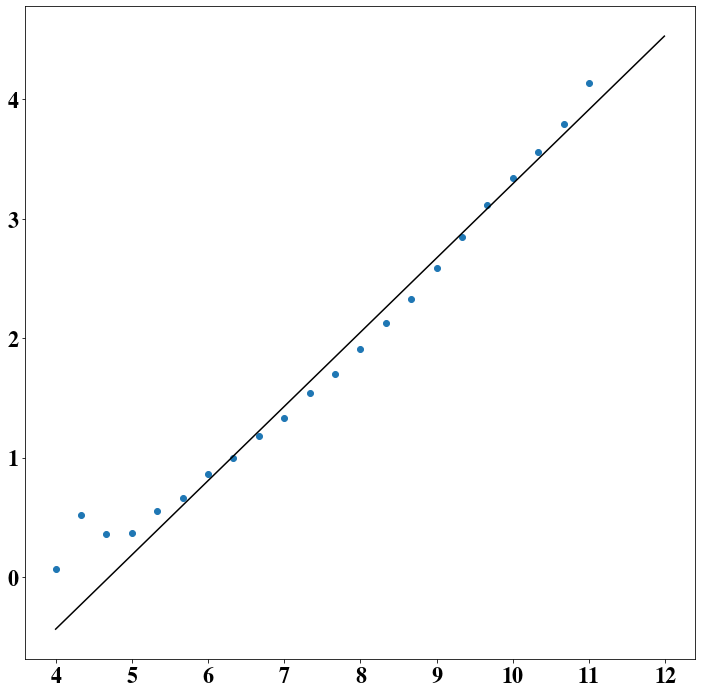

In [55]:
plt.scatter(mm1['normalized'], mm1['Estimated Protein Concentration (nM)'])
plt.plot(np.arange(4, 12, 0.01), fit_.predict(sm.add_constant(np.arange(4, 12, 0.01))), c = 'k')

In [56]:
# fit_ = sm.RLM(endog = np.log10(gg1['Estimated Protein Concentration (nM)'])[gg1['normalized'] != 0],
#        exog = sm.add_constant(np.log10(gg1['normalized'][gg1['normalized'] != 0])),
#        hasconst = True,
#        M = sm.robust.norms.TrimmedMean(1.37)).fit()

In [57]:
# fit_.summary()

Text(0, 0.5, 'Estimated Protein Concentration (nM) (log10)')

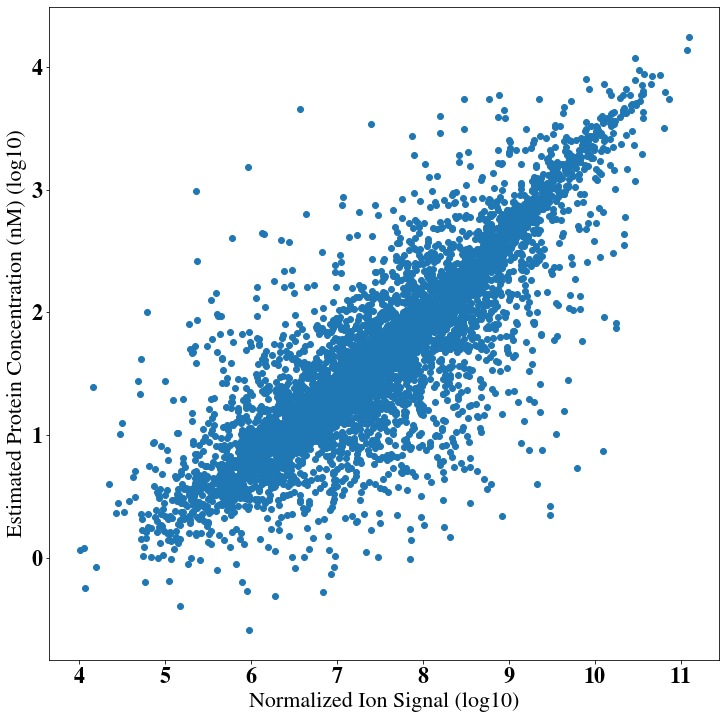

In [58]:
plt.scatter(np.log10(gg1['normalized'][gg1['normalized'] != 0]),
            np.log10(gg1['Estimated Protein Concentration (nM)'])[gg1['normalized'] != 0])
plt.xlabel('Normalized Ion Signal (log10)')
plt.ylabel('Estimated Protein Concentration (nM) (log10)')

In [59]:
xx1 = np.log10(gg1['normalized'][gg1['normalized'] != 0])

In [60]:
yy1 = np.log10(gg1['Estimated Protein Concentration (nM)'])[gg1['normalized'] != 0]

In [61]:
xx2 = np.arange(4, 11, 0.01)
yy2 = fit_.predict(sm.add_constant(np.arange(4, 11, 0.01)))

R[write to console]: `geom_smooth()` using formula 'y ~ x'

R[write to console]: `geom_smooth()` using formula 'y ~ x'



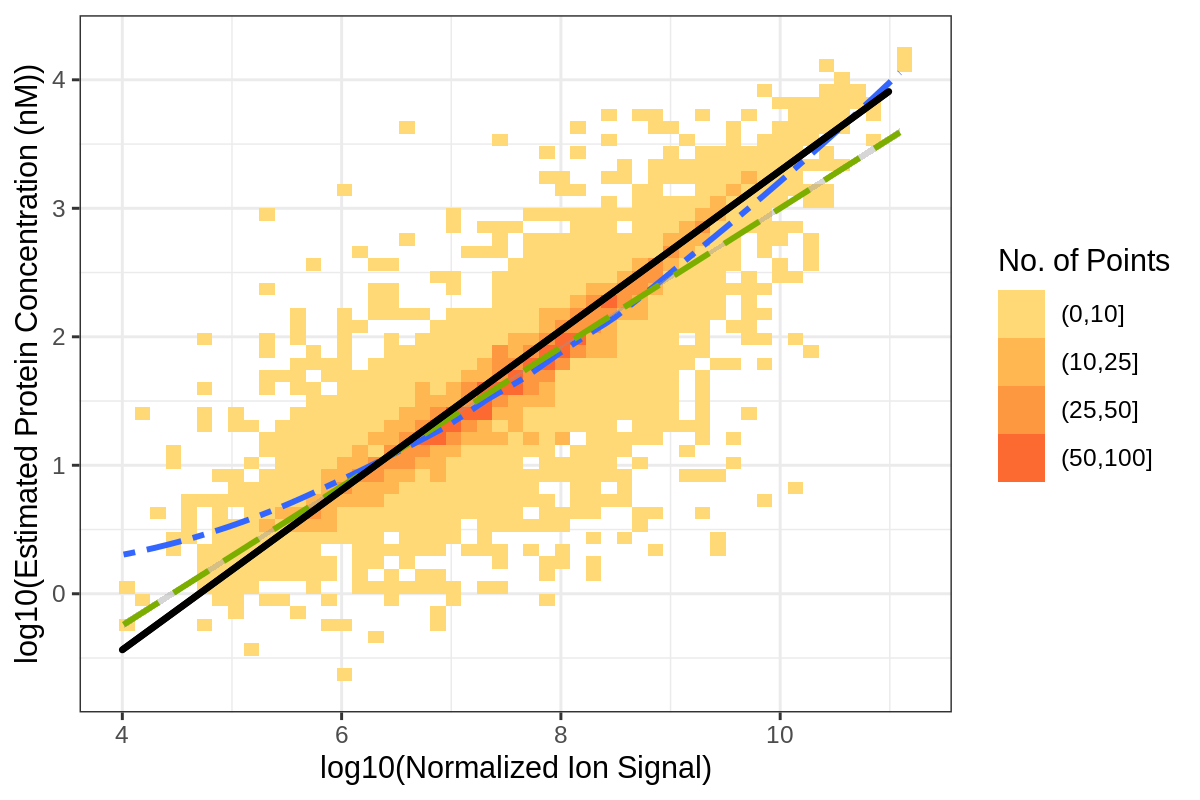

In [62]:
%%R -i xx1 -i yy1 -i xx2 -i yy2 -w 6 -h 4 --units in -r 200
ccc <- RColorBrewer::brewer.pal(n = 9, 'YlOrRd')
ccc <- ccc[3:9]
fill_breaks <- c(0, 10, 25, 50, 100, 250, 500, 1000, Inf)
ccc <- grDevices::colorRampPalette(ccc)(length(fill_breaks) - 1)

ggplot2::ggplot() +
    stat_summary_2d(aes(x = xx1,
                        y = yy1, z = xx1),
                    fun = function(x) cut(length(x), breaks = fill_breaks, right = TRUE), bins = c(50, 50)) +
    geom_smooth(aes(xx1,
                    yy1), method = 'loess', linetype = 'twodash', se = F, span = 0.4) +
    geom_smooth(aes(xx1,
                    yy1), method = 'lm', linetype = 'longdash', col = '#7CAE00', se = T) +
    geom_point(aes(xx2,
                    yy2), size = 0.5) +                
    xlab('log10(Normalized Ion Signal)') + ylab('log10(Estimated Protein Concentration (nM))') +
    #scale_x_continuous(breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1.0), limits = c(-0.01, 1.01)) +
    #scale_y_continuous(breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1.0), limits = c(-0.01, 1.01)) +
    scale_fill_manual(values = ccc, "No. of Points")# + ggsave(path, device = 'jpeg')

In [63]:
rr1 = gg1.copy(deep = True)

In [64]:
rr1['resid'] = gg1['Estimated Protein Concentration (nM)'].values - np.power(10, fit_.predict(sm.add_constant(np.log10(gg1['normalized'][gg1['normalized'] != 0]))).values)

In [65]:
rr1['fold_error'] = fit_.predict(sm.add_constant(np.log10(rr1['normalized'][rr1['normalized'] != 0]))).values - np.log10(rr1['Estimated Protein Concentration (nM)'])

In [66]:
rr1 = rr1.rename(columns = {'unique' : 'theoretical_num'})

In [67]:
rr1 = rr1.set_index(['ProteinId'])

In [68]:
#rr1 = rr1.join(pd.DataFrame(peps['Protein ID'].value_counts()))
rr1 = rr1.join(peps[['Protein ID', 'unique']].groupby('Protein ID').sum())

In [69]:
rr1 = rr1.rename(columns = {'unique' : 'num_detected'})

In [70]:
rr1['frac_detected'] = rr1['num_detected'] / rr1['theoretical_num']

R[write to console]: `geom_smooth()` using formula 'y ~ x'

R[write to console]: `geom_smooth()` using formula 'y ~ x'



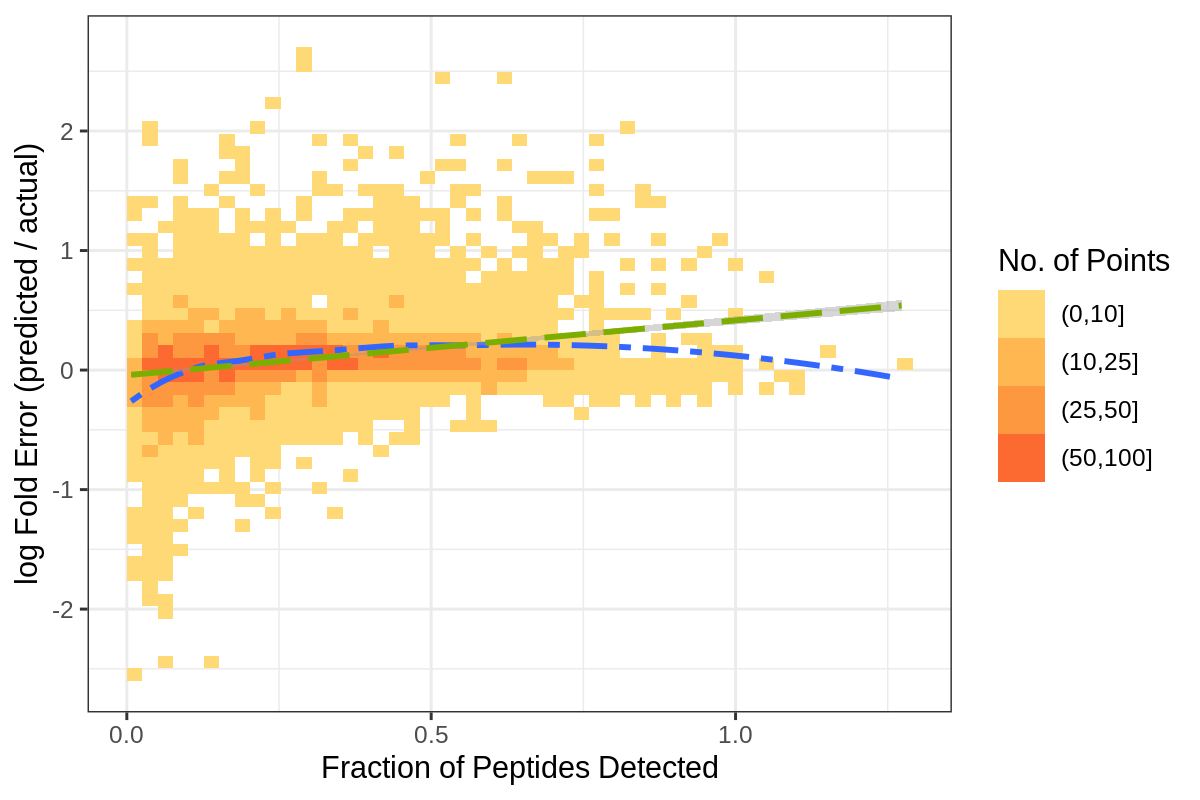

In [71]:
%%R -i rr1 -w 6 -h 4 --units in -r 200
ccc <- RColorBrewer::brewer.pal(n = 9, 'YlOrRd')
ccc <- ccc[3:9]
fill_breaks <- c(0, 10, 25, 50, 100, 250, 500, 1000, Inf)
ccc <- grDevices::colorRampPalette(ccc)(length(fill_breaks) - 1)

ggplot2::ggplot() +
    stat_summary_2d(aes(x = rr1$frac_detected,
                        y = rr1$fold_error, z = rr1$frac_detected),
                    fun = function(x) cut(length(x), breaks = fill_breaks, right = TRUE), bins = c(50, 50)) +
    geom_smooth(aes(rr1$frac_detected,
                    rr1$fold_error), method = 'loess', linetype = 'twodash', se = F, span = 0.4) +
    geom_smooth(aes(rr1$frac_detected,
                    rr1$fold_error), method = 'lm', linetype = 'longdash', col = '#7CAE00', se = T) +
    xlab('Fraction of Peptides Detected') + ylab('log Fold Error (predicted / actual)') +
    #scale_x_continuous(breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1.0), limits = c(-0.01, 1.01)) +
    #scale_y_continuous(breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1.0), limits = c(-0.01, 1.01)) +
    scale_fill_manual(values = ccc, "No. of Points")# + ggsave(path, device = 'jpeg')

R[write to console]: `geom_smooth()` using formula 'y ~ x'

R[write to console]: `geom_smooth()` using formula 'y ~ x'



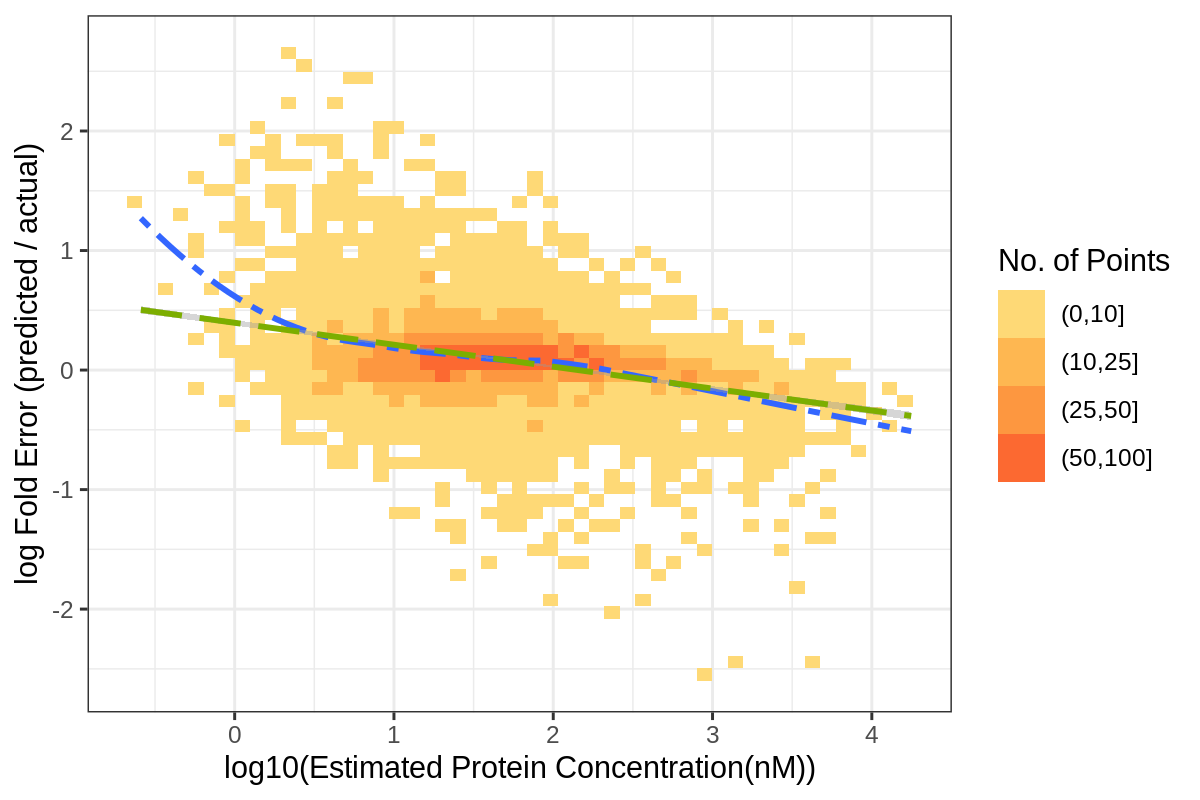

In [72]:
%%R -i rr1 -w 6 -h 4 --units in -r 200
ccc <- RColorBrewer::brewer.pal(n = 9, 'YlOrRd')
ccc <- ccc[3:9]
fill_breaks <- c(0, 10, 25, 50, 100, 250, 500, 1000, Inf)
ccc <- grDevices::colorRampPalette(ccc)(length(fill_breaks) - 1)

ggplot2::ggplot() +
    stat_summary_2d(aes(x = log10(rr1$`Estimated Protein Concentration (nM)`),
                        y = rr1$fold_error, z = rr1$`Estimated Protein Concentration (nM)`),
                    fun = function(x) cut(length(x), breaks = fill_breaks, right = TRUE), bins = c(50, 50)) +
    geom_smooth(aes(log10(rr1$`Estimated Protein Concentration (nM)`),
                    rr1$fold_error), method = 'loess', linetype = 'twodash', se = F, span = 0.4) +
    geom_smooth(aes(log10(rr1$`Estimated Protein Concentration (nM)`),
                    rr1$fold_error), method = 'lm', linetype = 'longdash', col = '#7CAE00', se = T) +
    xlab('log10(Estimated Protein Concentration(nM))') + ylab('log Fold Error (predicted / actual)') +
    #scale_x_continuous(breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1.0), limits = c(-0.01, 1.01)) +
    #scale_y_continuous(breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1.0), limits = c(-0.01, 1.01)) +
    scale_fill_manual(values = ccc, "No. of Points")# + ggsave(path, device = 'jpeg')

In [73]:
sp.stats.pearsonr(np.log10(gg1['normalized'][gg1['normalized'] != 0]),
           np.log10(gg1['Estimated Protein Concentration (nM)'])[gg1['normalized'] != 0])

(0.8430895087837323, 0.0)

In [74]:
normalized_signal['Estimated Concentration (nM)'] = 0
normalized_signal['Estimated Concentration (nM)'] += np.power(10, fit_.predict(sm.add_constant(np.log10(normalized_signal['normalized']))))

In [75]:
human_gene_map = pd.read_excel(os.path.join(data_dir, '210113_xenla_v9p2_humanGN.xlsx'), sheet_name = 1)

In [76]:
human_gene_map = human_gene_map.sort_values(by = ['humanGene', 'E_LtoH'], ascending = True)

In [77]:
human_gene_map['Top Hit Forward = Top Hit Reverse'] = human_gene_map.ProteinId.values == human_gene_map.sort_values(by = ['humanGene',
                                                                                                                          'E_HtoL'],
                                                                                                                    ascending = True).ProteinId.values

In [78]:
human_gene_map['Top Hit Forward = Top Hit Reverse'] = human_gene_map['Top Hit Forward = Top Hit Reverse'].astype(int)

In [79]:
human_gene_map['Top Hit Forward = Top Hit Reverse'] *= (1 - human_gene_map.E_HtoL.duplicated(keep = False).astype(int))

In [80]:
human_gene_map[human_gene_map.humanGene == 'A2M']

,ProteinId,laevisGene,human,humanGene,description,AA,E_LtoH,E_HtoL,Top Hit Forward = Top Hit Reverse
5715,gnl|gene15410|rna44977|,pzp-like.2.L,sp|P01023|A2MG_HUMAN,A2M,Alpha-2-macroglobulin,MWSSALALCLLFTALPGGDAAPPDPQYMLLVPTVLHGGGEEKFCLL...,0.000000e+00,0.000000e+00,0
7288,gnl|gene16891|rna49367|,ovos2.L,sp|P01023|A2MG_HUMAN,A2M,Alpha-2-macroglobulin,MSPNRFLLCVCILGLIAGGAAKVQYALTIPALLKSGETQRACVNLI...,0.000000e+00,0.000000e+00,0
27556,gnl|gene50021|rna96284|,a2m.S,sp|P01023|A2MG_HUMAN,A2M,Alpha-2-macroglobulin,MWSSALAFCLLLTAFPGGDSAPPHPKYMLLVPTVLHGGSEEKFCLL...,0.000000e+00,0.000000e+00,0
30448,gnl|gene7104|rna20743|,a2m.L,sp|P01023|A2MG_HUMAN,A2M,Alpha-2-macroglobulin,MWSSALALCLLFTALPGGDAALPDPKYMLLVPTVLHCGSEEKFCLL...,0.000000e+00,0.000000e+00,0
3120,gnl|gene12961|rna37674|,LOC108696037,sp|P01023|A2MG_HUMAN,A2M,Alpha-2-macroglobulin,MSPRGLLLCLSLLGIIAGGASKPQYALSIPALLKSGETATACINFV...,2.800000e-135,7.233333e-16,0
20809,gnl|gene41339|rna83741|,LOC108696028,sp|P01023|A2MG_HUMAN,A2M,Alpha-2-macroglobulin,MKQLCIDIYIQYTGSREKSNMALVEVKLLSGFIPLKNSVKKLVNSN...,1.980000e-34,1.700000e-33,0
14905,gnl|gene32732|rna72256|,LOC100491357.S,sp|P01023|A2MG_HUMAN,A2M,Alpha-2-macroglobulin,MFQRRFLCWVPILGLIGGVVSKPQHAFSIPFVLNKGKNTTACINFL...,1.040000e-33,3.130001e-08,0
17795,gnl|gene37448|rna78175|,LOC108695710,sp|P01023|A2MG_HUMAN,A2M,Alpha-2-macroglobulin,MLESINGNGGIHWERTNKPNAEKYPFFYAPAPSPEIEITAYILWGL...,5.960000e-33,4.020000e-32,0
16152,gnl|gene35331|rna75279|,LOC108697328,sp|P01023|A2MG_HUMAN,A2M,Alpha-2-macroglobulin,MLYNSEGHDSLNEFHSFVHFHWPLTSCLYCSYNGIKNQSNMAVVDM...,1.260000e-18,1.000000e-17,0


In [81]:
human_gene_map.to_excel(os.path.join(data_dir, 'Xenopus-v9p2_HumanGenes-map.xlsx'),
                        index = False)

In [82]:
human_gene_map = human_gene_map.set_index('ProteinId')

In [83]:
normalized_signal = normalized_signal.join(human_gene_map)

In [84]:
normalized_signal = normalized_signal.reset_index()

In [85]:
tt1 = normalized_signal.copy(deep = True)

In [86]:
normalized_signal = normalized_signal[normalized_signal.laevisGene.notna()]

In [87]:
normalized_signal['Top Hit Forward = Top Hit Reverse'].value_counts()

0.0    6586
1.0    3551
Name: Top Hit Forward = Top Hit Reverse, dtype: int64

In [88]:
tt2 = tt1[tt1.laevisGene.isna()][['Protein ID-v9p2', 'Area', 'unique', 'normalized',
                                  'Estimated Concentration (nM)', 'E_HtoL',
                                  'Top Hit Forward = Top Hit Reverse']]
tt2 = tt2.set_index('Protein ID-v9p2')
tt3 = pd.read_excel(os.path.join(data_dir, '210113_xenla_v9p2_humanGN.xlsx'),
                             sheet_name = 2).set_index('ProteinId')
tt2 = tt2.join(tt3)

In [89]:
tt2 = tt2.reset_index()

In [90]:
tt2 = tt2[['Protein ID-v9p2', 'Area', 'unique', 'normalized', 'Estimated Concentration (nM)',
          'laevisGene', 'human', 'humanGene', 'description', 'AA', 'E_LtoH', 'E_HtoL',
           'Top Hit Forward = Top Hit Reverse']]

In [91]:
normalized_signal = pd.concat([normalized_signal, tt2], axis = 0)

In [92]:
normalized_signal = normalized_signal[['Protein ID-v9p2', 'laevisGene', 'human', 'humanGene', 'description',
                                      'AA', 'E_LtoH', 'Top Hit Forward = Top Hit Reverse',
                                       'Area', 'unique', 'normalized',
                                       'Estimated Concentration (nM)']]

In [93]:
normalized_signal = normalized_signal.rename(columns = {'Area' : 'Total Area Signal (ions)',
                                                       'unique' : '# of Theoretical Peptides (Trypsin + LysC)',
                                                       'normalized' : 'Normalized Area Signal (ions / peptide)',
                                                       'human' : 'Protein ID-human',
                                                       'description' : 'Protein Description (human)',
                                                       'laevisGene' : 'Laevis Gene Name',
                                                       'humanGene' : 'Human Gene Name',
                                                       'Protein ID-v9p2' : 'Protein ID-Laevis v9p2',
                                                       'AA' : 'Protein Sequence (Laevis)',
                                                       'Estimated Concentration (nM)' : 'Estimated Protein Concentration (nM)'})

In [94]:
normalized_signal = normalized_signal.sort_values(by = 'Estimated Protein Concentration (nM)', ascending = False)

In [95]:
normalized_signal.head()

,Protein ID-Laevis v9p2,Laevis Gene Name,Protein ID-human,Human Gene Name,Protein Description (human),Protein Sequence (Laevis),E_LtoH,Top Hit Forward = Top Hit Reverse,Total Area Signal (ions),# of Theoretical Peptides (Trypsin + LysC),Normalized Area Signal (ions / peptide),Estimated Protein Concentration (nM)
4062,gnl|gene19662|rna57471|,serpina6.L,tr|A0A024R6I7|A0A024R6I7_HUMAN,SERPINA1,Alpha-1-antitrypsin,MHLLVYLSLFFALALASVTEISLDNKHRHRHEQQGHHDSAKHGHQK...,4.100000e-87,0.0,6.542843e+12,53,1.234499e+11,9365.218779
1835,gnl|gene14337|rna41761|,eno1.L,sp|P06733|ENOA_HUMAN,ENO1,Alpha-enolase,MSIKNIHAREIFDSRGNPTVEVDLYTCKGLFRAAVPSGASTGIYEA...,0.000000e+00,0.0,5.024281e+12,43,1.168437e+11,9050.495353
4165,gnl|gene19900|rna58110|,act3.S,sp|P68133|ACTS_HUMAN,ACTA1,"Actin, alpha skeletal muscle",MCDDDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,0.000000e+00,0.0,3.795172e+12,35,1.084335e+11,8639.892915
8512,gnl|gene54|rna164|,LOC100101274,sp|Q8WWU7|ITLN2_HUMAN,ITLN2,Intelectin-2,MLVYILLLLVVGGLSQPCSKSWEPLVMVASKNLANQLGCDKENTFR...,6.980000e-138,1.0,2.311308e+12,32,7.222837e+10,6711.726767
7770,gnl|gene4780|rna13948|,gapdh.L,sp|P04406|G3P_HUMAN,GAPDH,Glyceraldehyde-3-phosphate dehydrogenase,MAKVGINGFGRIGRLVTRAAFMSGKVQVVAINDPFIDLDYMVYMFK...,0.000000e+00,0.0,2.134578e+12,33,6.468417e+10,6266.952913


In [96]:
normalized_signal['Estimated Protein Concentration (nM)'].sum()

1949958.0057301472

In [97]:
normalized_signal['Top Hit Forward = Top Hit Reverse'].value_counts()

0.0    6586
1.0    3551
Name: Top Hit Forward = Top Hit Reverse, dtype: int64

In [98]:
normalized_signal.to_excel(os.path.join(data_dir, 'XenopusProteinConcentrationEstimates.xlsx'), index = False)

In [99]:
normalized_signal = normalized_signal.dropna(axis = 0)

In [100]:
grouped_signal = normalized_signal.groupby('Human Gene Name').sum().reset_index()[['Human Gene Name',
                                                                  'Total Area Signal (ions)',
                                                                 '# of Theoretical Peptides (Trypsin + LysC)',
                                                                 'Normalized Area Signal (ions / peptide)',
                                                                 'Estimated Protein Concentration (nM)']]

In [101]:
grouped_signal = grouped_signal.rename(columns = {'Estimated Protein Concentration (nM)' : 'Estimated Concentration (nM)'})

In [102]:
grouped_signal = grouped_signal.sort_values(by = 'Estimated Concentration (nM)', ascending = False)

In [103]:
grouped_signal.head()

,Human Gene Name,Total Area Signal (ions),# of Theoretical Peptides (Trypsin + LysC),Normalized Area Signal (ions / peptide),Estimated Concentration (nM)
2586,HBZ,2.107645e+12,94,1.148575e+11,14636.105283
5485,SERPINA1,6.784501e+12,181,1.288436e+11,11291.891712
1921,ENO1,5.416528e+12,84,1.264107e+11,10961.074217
2278,GAPDH,3.223105e+12,96,9.767018e+10,10404.888313
3926,NME2,2.021997e+12,43,9.259318e+10,10119.966894


In [104]:
grouped_signal.to_excel(os.path.join(data_dir, 'XenopusProteinConcentrationEstimatesGroupedByGene.xlsx'),
                        index = False)